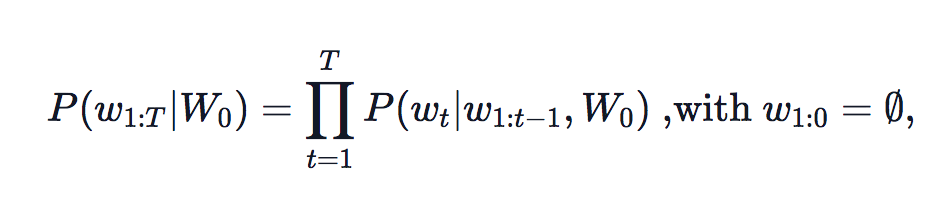
- 自回归语言生成是基于马尔可夫假设，即单词序列的概率分布可以分解为单词的条件概率乘积

本笔记中，我们会学习当前最流行的解码/文本生成方式
1. Greedy Search
2. Beam Search
3. Top-K Sampling
4. Top-P Samping

我们会使用 GPT2 模型作为案例，验证不同方式的效果

In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q tensorflow

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

# 使用 gpt2 自带的tokenizer 作为分词器
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# 引入模型
# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


## Greedy Search 贪心搜索

![image](https://huggingface.co/blog/assets/02_how-to-generate/greedy_search.png)

- Greedy Search 贪心搜索：永远只选择概率最大的词作为当前时间步的输出内容
- P("The","nice","woman") = 0.5 x 0.4 = 0.2

In [6]:
# 我们使用 '"I","enjoy","walking","with","my","cute","dog"' 作为上文文本，让 GPT2 帮助我们生成文本
# 将输入文本进行文本标签化/向量化
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='tf')
# 让gpt2模型基于我们的输出50个字符的文本
greedy_output = model.generate(input_ids, max_length = 50)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure if I'll


- 通过生成的文本我们可以看出，续写的文本是有逻辑性的，但是却很快就开始重复自身的内容，这又很糟糕了。。
- 贪心搜索的主要缺点是它错过了隐藏在低概率词后面的高概率词，当前时间步下的高概率词不代表他就是最合适好的答案
- 比如上面的图片中，如果选择了`dog`作为第一个词后，我们才能选到条件概率更高的`has`，但是按照 Greedy Search 的方式，我们将会错过 `The dog has` 这样一串符合语义的文本序列组合 

## Beam Search 束搜索

- Beam Search 基于束的数量N，留下概率最高的N个文本序列组合集，最终选择组合集中概率最大的那一个组合进行输出
- 对于一个 Beam = 2 的Beam Search：

![BS](https://huggingface.co/blog/assets/02_how-to-generate/beam_search.png)

1. 在第一步时，除了可能性最高的组合 'The nice' 之外，也保留了第二高可信的组合 'The dog'
2. 在第二步时，则采用了 "The","dog","has" 这组 0.36 概率的组合，而概率次高的组合者变成了 "The","nice","woman" 0.2 的概率
3. Beam search 总是会找到比贪心搜索概率更高的输出序列，但不保证找到最有可能的输出（因为Number of Beam 的取值不可能是过大）

In [7]:
# activate beam search and early_stopping
# 当生成过程遇到 EOS (End of sentence)时主动停止
# 设置生成过程的 Beam Number 为 5
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm not sure if I'll ever be able to walk with him again. I'm not sure if I'll


我们可以看出相比于之前，我们输出的文本变的更加流程了，但是仍然无法规避文本重复的问题
- 针对这一问题，2017年，[Paulus et al. (2017)](https://arxiv.org/abs/1705.04304) 提出使用 N-Gram 惩罚机制，确保在文本生成过程中，不会重复出现已有的 N-gram 短语

In [8]:
# set no_repeat_ngram_size to 2
# 在生成的过程中我们将N-Gram 惩罚值设置为2，也就是不会出现2-Gram的重复文本，看看效果如何
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to take a break


- 加入N-gram 惩罚机制之后，生成文本的重复现象改善了很多。
- 但是 N-Gram 惩罚机制并不是金手指，对于一篇针对于`New York` 这座城市的导览文章而言，使用 2-Gram惩罚将会导致`New York`这个地名组合在输出时仅出现一次，这会将这个导览变成一篇阅读理解，在这种场景下，我们将会很难N-Gram的N


我们也可以让模型在生成时生成多条高概率的文本，以供我们进行选择

In [9]:
# set return_num_sequences > 1
# 返回五条最高概率的输出，注意返回的输出数量不能超过 Number of Beam 的参数设置
beam_outputs = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    num_return_sequences=5, 
    early_stopping=True
)

# now we have 3 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to take a break
1: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to get back to
2: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with her again.

I've been thinking about this for a while now, and I think it's time for me to take a break
3: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with her again.

I've been thinking about this for a while now, and I think it's time for me to get back to
4: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about 

- 输出概率最高的5条输出结果好像并不能帮助我们获得更好的输出，每一条的输出结果只有细微的差距，这也是基于概率分布进行文本生成的最大问题，哪怕我们采用Top5的概率结果，文本的生成过程也很有可能陷入成求局部最优解的旋涡中

- 在[ Murray et al. (2018)](https://arxiv.org/abs/1808.10006) 的论文中，他们认为Beam Search 对于文本翻译和总结类型的任务，能够达成不错的结果，但是对于生成类/续写类的任务，则不太实用

- 虽然我们可以使用 N-Gram 惩罚来解决重复文本的问题，但是N的数字选取则是一个需要针对训练任务和训练集进行微调的桎梏

- 而在[ Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751) 的论文中，他参考了语言学的知识提出，人类的语言选择很多时候并不会基于高概率进行选择，相反我们会因为语境和内容选择低频词或是相反的概念词来进行表达（比如YYGQ），以避免我们的文本内容可预测或是无聊。

![Cons of BS](https://blog.fastforwardlabs.com/images/2019/05/Screen_Shot_2019_05_08_at_3_06_36_PM-1557342561886.png)

## Sampling 采样

- 基于文本的条件概率分布随机选取下一个文本
![sampleing](https://huggingface.co/blog/assets/02_how-to-generate/sampling_search.png)

- 因为是随机选取，所以文本的生成将不再具备确定性

In [10]:
# set seed to reproduce results. Feel free to change the seed though to get different results
# 随机采样的初始化参数，初始化成多少都可以
tf.random.set_seed(0)

# activate sampling and deactivate top_k by setting top_k sampling to 0
# 将Top-k置为0才能激活native sampling，不然会生成top-k sampling
# 这里讲 do_sample 置为 True 确保生成文本
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog and never seem to get nervous until it turns into battery Art Hours $50 of Weekend Bikes Friday Night A King's Approaches This was all, no problem WRONG!! WOWMS readers: excellent product!


- 生成的文本只能说是生成了，但是从含义上看基本上牛头不对马嘴
- 这也是native sampling 最大的问题，生成出来的文本是毫无含义的废话，连正确的废话都不是

于是，针对 native sampling 的问题，提出了一些解决思路（解决思路不是解决方案，我想解决，但是不一定解决掉了）

- 为了增加高概率词被选中的机会，降低低概率词被选中的机会，提出了`temperature` softmax 的概念

![temperature softmax](https://huggingface.co/blog/assets/02_how-to-generate/sampling_search_with_temp.png)

- 经过这样的处理之后，nice 相比于 car 拥有了更大的被选中概率，但是这样是不是又会陷入到 Greedy Search 的圈套里

In [11]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# use temperature to decrease the sensitivity to low probability candidates
# 设置 tempearture 为 0.7 目的是降低低概率词被选中的可能性
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0, 
    temperature=0.7
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))



Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog. I've always been an avid dog lover. My favorite type of dog is one that has been trained to do many things. I do not have any special preferences for particular breeds. I don't think I have


- 通过生成的结果，我们可以看到这段文本的生成小果好了很多
- 采用temperature的方式的确可以让我们的文本生成好一些
- 但是如果将temperature 设置为趋近0，那其实我们的 Sampling 其实就是贪婪搜索了

## Top-K Sampling

[Fan et. al (2018)](https://arxiv.org/pdf/1805.04833.pdf) 在论文中提出了temperature 的升级思路，称为 Top-K sampling

- Top-K 如其名，会优先选择K个概率最大的文本选择作为子集，再对选择好的子集进行softmax概率分布计算

- GPT2 模型默认采用的就是 Top-K sampling 的思路

![Top-k](https://huggingface.co/blog/assets/02_how-to-generate/top_k_sampling.png)

- 当我们选择K为6，也就是 TOP6 时，我们会选择6个概率最大的可能文本，
- 对于左边这个较为稀疏的概率分布状况，我们会比较均匀的获取到6个可能的选择，但是剔除掉的其他概率也不低的选择，这些文本看起来也是有可能会作为文本生成过程中的要素的内容的
- 但是语义右侧而言，我们则是获取到了概率分布不那么均匀的文本，剔除了一些不太合理的选择，但是却保留了 down 和 a 这样的文本

In [12]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# set top_k to 50
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=50
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog in the street from 2 1/2 miles (just before sunset) to 3 miles. But there are a few things that you need to know! It's NOT A REPUBLICANS EXCELLENT!


我们可以看到，相比于之前的结果，我们获取了相当不错的成果。

但是，TOP-K 的 K 作为一个超参数，必然会带来一些超参数的fine-tune问题，K作为一个正整数，无法动态地应对不同时间步的文本概率分布（平滑和尖锐的概率分布）

因此，将样本池限制为固定大小 K 可能会导致模型在遇到尖锐的概率分布时产生毫无意义的文本，同时却限制了模型在面对平滑分布时的创造力

## Top-P(Nucleus) Sampling

于是，针对 Top-P scaling 的问题，[Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751) 论文中提出了一个动态的方案 Top-P scaling

- 与固定的K值不同，从累积概率超过概率 p 的最小可能单词集中选择文本作为备选，换句话来说，就是将固定的数字选择转换为动态的概率分布选择，以规避概率分布形状不同导致的选择问题（这样创建的子集数量是波动的）
- 与Top-P同样的思路，选择之后子集再进行 softmax 重新计算概率分布

![topp](https://huggingface.co/blog/assets/02_how-to-generate/top_p_sampling.png)

- 在设置 p = 0.92 的情况下，对于第一个平滑的概率分布，我们会选取到9个候选词；而对第二个尖锐的概率分布而言，我们则只会选择3个候选词，有效地解决了分布形态的问题

In [13]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# deactivate top_k sampling and sample only from 92% most likely words
# 注意设置topk 为0，而top-p则设置为0.92 确保效果的独立性
# topk与topp 并不是不能混用
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_p=0.92, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog and very often see her immediately excited at moving on." - Alicia Davis

Recently, running around Los Angeles on an expeditions had me thinking, "What'd I get for free here?" I worked as a


看起来，写出来的文本更有故事的味道了，虽然不知道是什么故事

虽然我们刚刚的代码中，没有加入 topk的参数，但是从实际应用上，我们可以将topk和topp混合使用，可以解决在平均概率较低的平滑分布上，选取某些的极低概率的词

In [14]:
# 结合topk 和 topp 来试试效果
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True, 
    max_length=50, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog

In my life I love having fun

What does it cost to feed a cat to get a heart attack?

I think, this is actually a really good question: what are some of the
1: I enjoy walking with my cute dog as much as I do driving my car. It's the best way to spend a Saturday without missing a beat.

5/5 - My favorite weekend in my life. The weekend I really wanted is Tuesday
2: I enjoy walking with my cute dog, I like to get a dog from the grocery store and it's been a pleasure to sit and talk to her (when she is sleeping), and she's been so happy with our visit to the supermarket (we


相比于 Beam Search 的方式，我们生成的文本随机性更高了，并且并没有牺牲有效性（生成胡言乱语的文本）

## Summary

- 从目前业内尝试的经历来看，topp和topk 比 贪心搜索和Beam Search 生成的效果更好
- 但是从学界的[论文](https://arxiv.org/pdf/1908.04319.pdf)来看，循环生成文本的问题似乎是模型导致的，而非生成文本的docode 方法导致的
- 而且，[论文](https://arxiv.org/abs/2002.02492)表明，基于Topp和topk生成的文本也有重复的问题存在
- 也有[论文](https://arxiv.org/pdf/1908.04319.pdf)表示，Beam search 相比于 Topk ，生成的文本经过人的评估更加流程
